In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd

cudnn.benchmark = True
plt.ion()   # interactive mode

In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/tljh/user/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
all_path_corr = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/with_color_correction/All/'
first_path_corr = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/with_color_correction/1/'
second_path_corr = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/with_color_correction/2/'

all_path = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/without_color_correction/All/'
first_path = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/without_color_correction/1/'
second_path = '/home/jupyter-fly_cv/Igor/Plants/Dataset for ResNet/without_color_correction/2/'


all_path_new ='/home/jupyter-fly_cv/Igor/Plants/Dataset_for_ResNet_NEW/All/'
first_path_new ='/home/jupyter-fly_cv/Igor/Plants/Dataset_for_ResNet_NEW/first/'
second_path_new ='/home/jupyter-fly_cv/Igor/Plants/Dataset_for_ResNet_NEW/second/'

example_path = '/home/jupyter-fly_cv/Igor/Plants/Class_example/hymenoptera_data/'

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(448),
        transforms.Resize(512),
      #  transforms.CenterCrop(448),
        transforms.RandomHorizontalFlip(),
     #   transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(512),
       # transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(512),
       # transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = second_path
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

class_names = image_datasets['train'].classes

print(class_names)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

['гаплоид', 'диплоид']


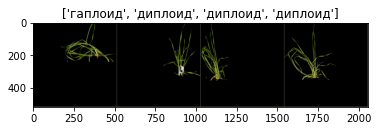

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    L_tr = list()
    Acc_tr = list()
    
    L_val = list()
    Acc_val = list()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_train = 0.0
    acc_train = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    labels = labels 
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
           
            if phase == 'train':
                L_tr.append(float(epoch_loss))
                Acc_tr.append(float(epoch_acc))
                
            if phase == 'val':
                L_val.append(float(epoch_loss))
                Acc_val.append(float(epoch_acc))


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                acc_train = epoch_acc
            
            # deep copy the model
            if phase == 'val' and epoch_acc >= best_acc:
                if best_acc == epoch_acc:
                    if best_acc_train <= acc_train:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                        best_acc_train = acc_train
                        print('new_best')
                if best_acc != epoch_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print('new_best')
               # best_model_wts = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    print(f'Train Acc: {best_acc_train:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    index = np.arange(num_epochs)
    data_l = {'train_l':L_tr,
            'val_l':L_val}
    df_l = pd.DataFrame(data_l)
    
    data_accur = {'train':Acc_tr,
            'val':Acc_val}
    df_accur = pd.DataFrame(data_accur)
    
    fig, (ax1, ax2) = plt.subplots(1,2)
    
    ax1.plot(index,df_l)
    ax2.plot(index, df_accur)
    
    ax1.grid()
    ax2.grid()
    
    
    ax1.set_xlabel('epoches')
    ax1.set_ylabel('value')
    
    ax2.set_xlabel('epoches')
    ax2.set_ylabel('value')
    
    plt.legend(data_l, loc=1)
    plt.legend(data_accur, loc=2)
    
    plt.subplots_adjust(wspace= 1, hspace=0)
    
    plt.show()
    
    return model

In [7]:
def test_model(model):
    since = time.time()

    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

            # Iterate over data.
    for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            labels = labels 
            loss = criterion(outputs, labels)

                # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    
            epoch_loss = running_loss / dataset_sizes['test']
            epoch_acc = running_corrects.double() / dataset_sizes['test']
            
    return  float(epoch_loss),float(epoch_acc)

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [9]:
model_18 = torchvision.models.resnet18(pretrained=True)
for param in model_18.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_18.fc.in_features
model_18.fc = nn.Linear(num_ftrs, 2)

model_18 = model_18.to(device)


model_50 = torchvision.models.resnet50(pretrained=True)
for param in model_50.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_50.fc.in_features
model_50.fc = nn.Linear(num_ftrs, 2)

model_50 = model_50.to(device)


model_101 = torchvision.models.resnet101(pretrained=True)
for param in model_101.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_101.fc.in_features
model_101.fc = nn.Linear(num_ftrs, 2)

model_101 = model_101.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_18 = optim.Adam(model_18.fc.parameters(), lr=0.005)
optimizer_50 = optim.Adam(model_50.fc.parameters(), lr=0.0025)
optimizer_101 = optim.Adam(model_101.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 20 epochs
exp_lr_scheduler_18 = lr_scheduler.StepLR(optimizer_18, step_size=10, gamma=0.25)
exp_lr_scheduler_50 = lr_scheduler.StepLR(optimizer_50, step_size=10, gamma=0.25)
exp_lr_scheduler_101 = lr_scheduler.StepLR(optimizer_101, step_size=10, gamma=0.25)

Epoch 0/49
----------
train Loss: 0.9412 Acc: 0.4743
val Loss: 1.3171 Acc: 0.4839
new_best

Epoch 1/49
----------
train Loss: 1.0954 Acc: 0.4971
val Loss: 1.0332 Acc: 0.4919
new_best

Epoch 2/49
----------
train Loss: 0.7055 Acc: 0.5657
val Loss: 1.0639 Acc: 0.4919
new_best

Epoch 3/49
----------
train Loss: 0.8647 Acc: 0.5429
val Loss: 0.8331 Acc: 0.3952

Epoch 4/49
----------
train Loss: 0.6821 Acc: 0.6229
val Loss: 0.9572 Acc: 0.4435

Epoch 5/49
----------
train Loss: 0.7557 Acc: 0.6114
val Loss: 0.9078 Acc: 0.4274

Epoch 6/49
----------
train Loss: 0.7018 Acc: 0.5943
val Loss: 1.4263 Acc: 0.4839

Epoch 7/49
----------
train Loss: 0.6380 Acc: 0.6400
val Loss: 1.9304 Acc: 0.4839

Epoch 8/49
----------
train Loss: 0.6328 Acc: 0.6629
val Loss: 1.1603 Acc: 0.4435

Epoch 9/49
----------
train Loss: 0.9042 Acc: 0.5771
val Loss: 1.0096 Acc: 0.4274

Epoch 10/49
----------
train Loss: 0.5907 Acc: 0.6571
val Loss: 1.0773 Acc: 0.4355

Epoch 11/49
----------
train Loss: 0.5433 Acc: 0.7029
val L

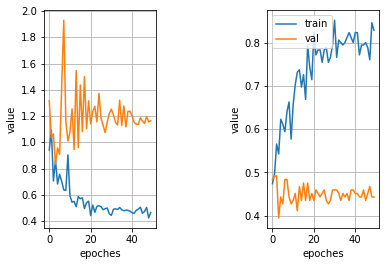

In [10]:
model_18 = train_model(model_18, criterion, optimizer_18,
                         exp_lr_scheduler_18, num_epochs = 50)

In [11]:
torch.save(model_18, 'ResNet18_second')

In [12]:
test_model(model_18)

(0.9938164802697989, 0.5230769230769231)

Epoch 0/74
----------
train Loss: 0.9060 Acc: 0.5543
val Loss: 1.5904 Acc: 0.5161
new_best

Epoch 1/74
----------
train Loss: 0.8534 Acc: 0.5886
val Loss: 0.7571 Acc: 0.4435

Epoch 2/74
----------
train Loss: 0.7371 Acc: 0.5829
val Loss: 1.1904 Acc: 0.4839

Epoch 3/74
----------
train Loss: 1.0125 Acc: 0.5086
val Loss: 0.8398 Acc: 0.4516

Epoch 4/74
----------
train Loss: 0.7827 Acc: 0.5771
val Loss: 1.4240 Acc: 0.4839

Epoch 5/74
----------
train Loss: 0.8288 Acc: 0.6114
val Loss: 0.9226 Acc: 0.3952

Epoch 6/74
----------
train Loss: 0.8583 Acc: 0.6400
val Loss: 1.9093 Acc: 0.4839

Epoch 7/74
----------
train Loss: 0.8088 Acc: 0.6229
val Loss: 1.0862 Acc: 0.4677

Epoch 8/74
----------
train Loss: 0.5843 Acc: 0.6743
val Loss: 0.9276 Acc: 0.4839

Epoch 9/74
----------
train Loss: 0.6433 Acc: 0.6857
val Loss: 1.3102 Acc: 0.4677

Epoch 10/74
----------
train Loss: 0.5972 Acc: 0.6971
val Loss: 0.8988 Acc: 0.4919

Epoch 11/74
----------
train Loss: 0.5617 Acc: 0.7371
val Loss: 0.9771 Acc: 0

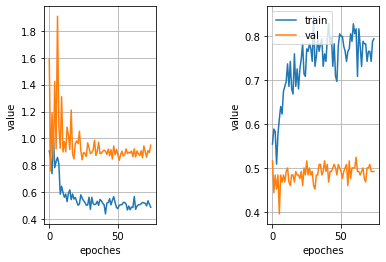

In [13]:
model_50 = train_model(model_50, criterion, optimizer_50,
                         exp_lr_scheduler_50, num_epochs = 75)

In [14]:
test_model(model_50)

(0.854130408855585, 0.5461538461538462)

In [15]:
torch.save(model_50, 'ResNet50_second')

Epoch 0/99
----------
train Loss: 0.7052 Acc: 0.5657
val Loss: 0.6949 Acc: 0.5484
new_best

Epoch 1/99
----------
train Loss: 0.7051 Acc: 0.5829
val Loss: 0.7683 Acc: 0.5242

Epoch 2/99
----------
train Loss: 0.7891 Acc: 0.5600
val Loss: 0.9218 Acc: 0.4758

Epoch 3/99
----------
train Loss: 0.6182 Acc: 0.6343
val Loss: 1.0116 Acc: 0.4839

Epoch 4/99
----------
train Loss: 0.6576 Acc: 0.6229
val Loss: 0.9125 Acc: 0.4839

Epoch 5/99
----------
train Loss: 0.6447 Acc: 0.6343
val Loss: 0.8185 Acc: 0.5081

Epoch 6/99
----------
train Loss: 0.6825 Acc: 0.6286
val Loss: 0.8933 Acc: 0.4274

Epoch 7/99
----------
train Loss: 0.6843 Acc: 0.6000
val Loss: 1.0815 Acc: 0.4839

Epoch 8/99
----------
train Loss: 0.7280 Acc: 0.5943
val Loss: 1.1041 Acc: 0.4677

Epoch 9/99
----------
train Loss: 0.5784 Acc: 0.7143
val Loss: 0.9048 Acc: 0.4516

Epoch 10/99
----------
train Loss: 0.6042 Acc: 0.6686
val Loss: 0.8784 Acc: 0.5242

Epoch 11/99
----------
train Loss: 0.5624 Acc: 0.7257
val Loss: 1.0112 Acc: 0

val Loss: 0.9663 Acc: 0.4597

Epoch 98/99
----------
train Loss: 0.5340 Acc: 0.7829
val Loss: 0.9595 Acc: 0.4758

Epoch 99/99
----------
train Loss: 0.5146 Acc: 0.8000
val Loss: 0.9291 Acc: 0.4839

Training complete in 12m 45s
Best val Acc: 0.548387
Train Acc: 0.000000


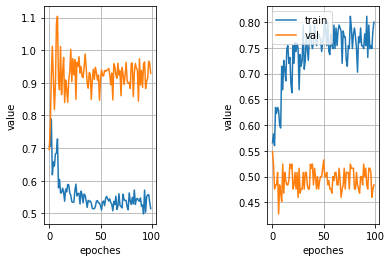

In [16]:
model_101 = train_model(model_101, criterion, optimizer_101,
                         exp_lr_scheduler_101, num_epochs = 100)

In [17]:
test_model(model_101)

(0.6966465390645541, 0.5307692307692308)

In [18]:
torch.save(model_101, 'ResNet101_second')